<a href="https://colab.research.google.com/github/nicholasrichers/Desafio-Cola-Cola-Sofazao/blob/master/DesafioPeta_Sofazao.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Resumo: Colocar aqui um resumo da análise até o momento...

# Setup

## Importando Bibliotecas

> Instalando Pacotes

In [47]:
!pip install pendulum

> Pacote Datetime usado nesse estudo

In [0]:
import os, random, re, sys, time, warnings
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from scipy.stats import pearsonr

pd.set_option('display.max_rows', 250)
pd.options.display.float_format = '{:,.2f}'.format

> Bibliotecas Privadas

In [49]:
!git clone https://github.com/nicholasrichers/Desafio-Cola-Cola-Sofazao.git

fatal: destination path 'Desafio-Cola-Cola-Sofazao' already exists and is not an empty directory.


> Chamamos a função load_library como no exemplo abaixo para importar as bibliotecas privadas.

```
load_library('lib_name', 'libraries/filename.py')

import lib_name
ou
from lib_name import function_name
```



In [0]:
from importlib.machinery import SourceFileLoader
def load_library(NAME_LIB, FILE_PATH):
  FILE_PATH = '/content/Desafio-Cola-Cola-Sofazao/Datathon_Peta/' + FILE_PATH
  somemodule = SourceFileLoader(NAME_LIB, FILE_PATH).load_module()



---



---



## Upload dataset

> Subimos os arquivos para um repositorio público no [github](https://github.com/nicholasrichers/Desafio-Cola-Cola-Sofazao/tree/master/Datathon%20Peta) para garantir que pode ser lido de qualquer máquina.



In [51]:
REPO_URL = 'https://raw.githubusercontent.com/nicholasrichers/Desafio-Cola-Cola-Sofazao/master/Datathon_Peta/datasets/'

df_vendas = pd.read_csv(REPO_URL + 'Alasca_nordeste.csv', sep=';')
df_macro = pd.read_csv(REPO_URL + 'macroeconomia.csv', sep=';')


print(f'Alasca Shape: {df_vendas.shape} || Macro Shape: {df_macro.shape}') 

Alasca Shape: (242, 14) || Macro Shape: (59, 8)


> Tudo ok com a importação dos 2 datasets.

In [52]:
df_vendas.head(2)

,Data,Total,SM,ROUTE,INDIRETOS,Week_445,Month_445,Day_gregoriano,Month_gregoriano,Year,Data.1,holidays,weekend,work_day
0,(01/jan) S 01/01/15,"1.140.939,79","53.836,01","445.628,58","279.716,45",1,1,1,1,2015,01/01/2015,1,0,0
1,(10/jan) S 02/01/15,"1.208.345,05","44.632,77","411.396,38","373.728,09",2,1,10,1,2015,10/01/2015,0,3,6


In [53]:
df_macro.head(2)

,Data,temperatura,Ocupacao,Ajuste_ipca,PMC,Massa.Renda,Renda,Desemprego
0,01/01/2015,"27,54","24.420,64","256,57","97,99","5.047.993,34","1.588,12","9,28"
1,01/02/2015,"27,66","24.420,64","259,70","85,23","5.047.993,34","1.588,12","9,28"




---



---



# Pré Processamento

## Dataset vendas

*Nessa seçao vamos fazer um primeiro contato com cada coluna, Para identificar potenciais erros e necessidade de colunas adicionais.*

### Coluna: **Data**

> Observações:

1.     *(17/Jan)* - Data exata no calendario gregoriano
2.     *S* - Todas as datas selecionadas caem num sábado
3.     *03/01/15* - A primeira informação '03' remete a 3ª semana do mes '01' seguindo o calendário 4-4-5

In [54]:
df_vendas['Data'].iloc[2]

'(17/jan) S 03/01/15'



---



---



### Colunas: **Total, SM, Route e Indiretos**

> *Observações:*

1. As 3 colunas são do tipo string, vamos convertê-las para numérico
2. *SM* = Supermercado, Route = Bares e lanchonetes, Indiretos = Depositos e Distribuidoras. 
3. Criaremos um canal "Outros" para a soma dos canais dar igual ao Total.

In [55]:
df_vendas.iloc[:, 1:5].dtypes

Total        object
SM           object
ROUTE        object
INDIRETOS    object
dtype: object

> Como o google colab nao possui o tipo 'pt_BR.utf8', teremos que alterar o formato dos numeros manualmente via regex

In [56]:
!locale -a

C
C.UTF-8
en_US.utf8
POSIX


In [0]:
load_library('adjust_datatype', 'libraries/adjust_datatype.py')
from adjust_datatype import PT_BR_string_to_numeric

In [0]:
for col in df_vendas.columns[1:5]: 
  df_vendas[col] = PT_BR_string_to_numeric(df_vendas, col)

> Criando o quarto canal de vendas "Outros". Vemos que esse canal representa geralmente um terço do volume de vendas que não consta do banco de dados.

In [0]:
df_vendas['OUTROS'] = df_vendas['Total'] - df_vendas[df_vendas.columns[2:5]].sum(axis=1)

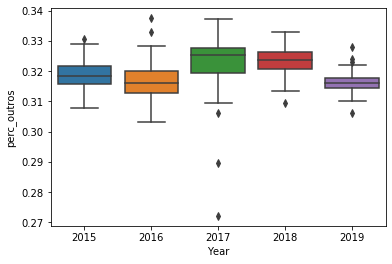

In [60]:
df_vendas['perc_outros'] = df_vendas['OUTROS'] / df_vendas['Total']
sns.boxplot(y='perc_outros', x='Year', data=df_vendas)



---



---



### Colunas **Week_445,	Month_445,	Day_gregoriano,	Month_gregoriano,	Year,	Data.1**

*Observações:*


1.   Em algumas linhas o "Month_445" está diferente do "Month_gregoriano"
2.   Existem Alguns erros similares para a coluna "week_445"
3.   Como já existe uma coluna chamada "Data", o pandas renomeuou para "Data.1".





Percebemos esse descasamento entre as colunas "Month_445" e "Month_gregoriano", sempre na ultima semana de alguns meses, devido ao formato do calendário 445, essas diferenças podem atrapalhar na hora de plotar gráficos, então criaremos colunas provisórias para esse fim. 

In [61]:
df_vendas[df_vendas.Month_445 != df_vendas.Month_gregoriano].iloc[:,[0,6,8]].head(6)

,Data,Month_445,Month_gregoriano
4,(31/jan) S 01/02/15,2,1
8,(28/fev) S 01/03/15,3,2
21,(30/mai) S 01/06/15,6,5
34,(29/ago) S 01/09/15,9,8
43,(31/out) S 01/11/15,11,10
47,(28/nov) S 01/12/15,12,11


Vamos também renomear a coluna Data.1 para Datetime, e trocar o tipo para datetime.

In [0]:
df_vendas.rename(columns={'Data.1':'Datetime'}, inplace=True)
df_vendas['Datetime'] = pd.to_datetime(df_vendas['Datetime'], format='%d/%m/%Y')

Criamos uma coluna similar a "week_445" chamada "week_month", a para evitar inconsistências.

In [0]:
load_library('adjust_datetime', 'libraries/adjust_datetime.py')
from adjust_datetime import week_of_month

In [0]:
df_vendas['Week_Month'] = df_vendas['Datetime'].map(week_of_month)

Aproveitamos para criar uma coluna "week_year", que será util mais a frente.

Obs: A função dt.weekofyear do pandas  retorna 52 para o dia 1-Jan, seguindo o [padrão ISO](https://stackoverflow.com/questions/44372048/python-pandas-timestamp-week-returns-52-for-first-day-of-year/44372130), contudo essa diferença causou alguns problemas na análise na seção subsequente, então optamos por inserir a coluna "week_year" manualmente.

In [0]:
df_vendas['Week_Year'] = ([i for i in range(1,53)]*5)[0:242] #df_vendas['Datetime'].dt.weekofyear



---



---



### Colunas **holidays,	weekend,	work_day**

*Observações:*


1.  A soma das 3 colunas deveria dar 7
2.  Maior parte das colunas dão {h: 0, w:2, wd: 5} como esperado.
3.  Sempre há diferenças na primeira e segunda semana de cada ano, e em algumas com feriado
4. Isso acontece porque alguns intervalos não tem uma diferença de 7 dias como se supunha.


In [66]:
df_vendas[(df_vendas.holidays + df_vendas.weekend + df_vendas.work_day) != 7].iloc[:, 9:14]

,Year,Datetime,holidays,weekend,work_day
0,2015,2015-01-01,1,0,0
1,2015,2015-01-10,0,3,6
46,2015,2015-11-21,1,2,5
52,2016,2016-01-01,1,1,4
53,2016,2016-01-09,0,3,5
70,2016,2016-05-07,1,2,5
104,2017,2017-01-01,2,3,5
105,2017,2017-01-07,0,1,5
156,2018,2018-01-01,2,3,4
157,2018,2018-01-06,0,1,4




---



---



## Dataset Macro

*Primeira análise das colunas do dataset MACRO*

Dicionário Colunas:
1. *Data*: Mensal entre Jan-2015 e Nov-2019 (vendas => Ago-2019)
2. *Temperatura*: Média mensal
3. *Ocupação*: Taxa inversa ao desemprego, mas inclui economia informal
4. *Ajuste_ipca*: Calcula a variação percentual entre cada mês da tabela q vc vai ter o IPCA daquele mês
5. *PMC*: Pesquisa Mensal do Comércio (IBGE)
6. *Massa.Renda*: (pop * renda_ppc)
7. *Renda*: Renda Per Capita NE (IBGE)
8. *Desemprego*: Taxa(%) desemprego NE

> Agora vamos analisar o tipo das colunas do **Dataset Macro**, e fazer os ajutes necessários

In [67]:
df_macro.dtypes

Data           object
temperatura    object
Ocupacao       object
Ajuste_ipca    object
PMC            object
Massa.Renda    object
Renda          object
Desemprego     object
dtype: object

> Vamos passar a coluna **Data** para o tipo datetime.

In [0]:
df_macro['Data'] = pd.to_datetime(df_macro['Data'], format='%d/%m/%Y')

> Vamos ajustar os valores do tipo string para numérico, como feito na seção anterior, para todas as outras colunas

In [0]:
for col in df_macro.columns[1::]: 
  df_macro[col] = PT_BR_string_to_numeric(df_macro, col)

> Usamos o método describe em busca de potenciais valores nulos e outliers para esse dataset, aparentemente o valor fora da curva se encontra na coluna **Massa.Renda** que possui um valor mínimo muito abaixo do 1º Quartil, indicando um possível **outlier**.

In [70]:
df_macro.describe()

,temperatura,Ocupacao,Ajuste_ipca,PMC,Massa.Renda,Renda,Desemprego
count,59.00,59.00,59.00,59.00,59.00,59.00,59.00
mean,27.03,"23,383.11",300.24,87.50,"4,229,405.91","1,572.52",13.32
std,0.82,605.27,19.77,8.63,"1,571,830.71",38.98,1.90
min,25.06,"22,420.47",256.57,75.31,"1,615.21","1,500.53",9.28
25%,26.29,"22,954.20",288.70,82.65,"4,611,945.20","1,541.01",12.70
50%,27.29,"23,363.04",302.34,85.25,"4,794,792.25","1,576.33",13.90
75%,27.66,"23,688.78",316.55,89.53,"4,952,818.40","1,601.76",14.44
max,28.31,"24,420.64",329.48,115.78,"5,047,993.34","1,619.34",15.82


> Olhando esse valor mais de perto vemos claramente que esse valor (Massa.Renda = 1615.21) foi inserido de forma errada, replicando o valor da coluna subsequente, vamos tratar esse e demais erros na próxima seção.

Obs: Até o momento usamos apenas os dados macro até Ago-2019, periodo do dataset vendas, logo esse registo com erro foi cortado

In [71]:
df_macro.tail(10)

,Data,temperatura,Ocupacao,Ajuste_ipca,PMC,Massa.Renda,Renda,Desemprego
49,2019-02-01,27.48,"22,966.75",320.79,79.01,"1,615.21","1,615.21",15.20
50,2019-03-01,27.51,"23,089.94",323.19,82.65,"1,619.34","1,619.34",14.97
51,2019-04-01,27.19,"23,321.52",325.03,81.92,"4,830,741.06","1,615.21",13.98
52,2019-05-01,26.54,"23,363.04",325.46,82.65,"4,830,713.16","1,615.21",14.07
53,2019-06-01,25.96,"23,352.33",325.51,81.92,"4,830,713.16","1,615.21",14.24
54,2019-07-01,25.55,"23,833.07",326.33,85.37,"4,957,543.20","1,615.21",13.80
55,2019-08-01,25.95,"23,769.46",326.74,79.01,"4,830,713.16","1,615.21",13.90
56,2019-09-01,26.64,"23,680.63",327.62,85.37,"4,957,543.20","1,619.34",13.98
57,2019-10-01,27.44,"23,694.88",328.55,110.62,"1,615.21","1,615.21",13.99
58,2019-11-01,27.83,"23,682.69",329.48,85.37,"4,957,543.20","1,615.21",13.97




---

---


# Selecão de variáveis

## Dataset Vendas

> **Features** altamente **correlacionadas** acabam perdendo perdendo relevância na tomada de decisão do modelo, **dificultando a interpretabilidade**. Para calcular a correlação entre as colunas vamos usar o coeficiente de correlação de **Pearson R**, para todas as possíveis combinações de colunas.

In [0]:
num_feat = df_vendas.select_dtypes('number').columns.values
comb_num_feat = np.array(list(combinations(num_feat, 2)))
corr_num_feat = np.array([])

for comb in comb_num_feat:
  corr = pearsonr(df_vendas[comb[0]], df_vendas[comb[1]])[0]
  corr_num_feat = np.append(corr_num_feat, corr)

> Agora vamos analisar os pares de colunas com **correlação acima de |0.9|**

*Observações:*


1.  *Total*:  Possui alta correlação com todos os outros canais como esperado
2.  *Outros*: Também possui alta correlação com os outros canais por ser uma coluna derivada das mesmas (podendo ser descartada futuramente).
3.  *O par ["Month_445", "Month_gregoriano"]*: também está altamente correlacionado por obvio, não fazendo sentido manter ambas, logo iremos **descartar** a coluna **"Month_445"** porque foram encontradas algumas inconsistências nessa coluna durante a fase de pré-processamento

In [73]:
high_corr_num = comb_num_feat[np.abs(corr_num_feat) >= 0.9]
high_corr_num

array([['Total', 'ROUTE'],
       ['Total', 'INDIRETOS'],
       ['Total', 'OUTROS'],
       ['ROUTE', 'OUTROS'],
       ['INDIRETOS', 'OUTROS'],
       ['Month_445', 'Month_gregoriano'],
       ['Month_445', 'Week_Year'],
       ['Day_gregoriano', 'Week_Month'],
       ['Month_gregoriano', 'Week_Year']], dtype='<U16')

> Vemos também que as colunas "work_day" e "weekend", apresentam quase sempre o mesmo valor, que como vimos na fase de pré-processamento, derivam da coluna "holidays", então iremos manter apenas essa última.

In [74]:
wd5 = df_vendas[(df_vendas['work_day']== 5)].shape[0]/df_vendas.shape[0]
wk2 = df_vendas[(df_vendas['weekend']== 2)].shape[0]/df_vendas.shape[0]

print(f'week_day = 5: {wd5*100:.0f}% || weekend = 2: {wk2*100:.0f}%') 

week_day = 5: 82% || weekend = 2: 96%


Além disso, a coluna "Data" possui um formato difícil de ser tratado e já possuímos a coluna "datetime" idêntica", logo também será descartada.

In [0]:
drop_cols = ['Data', 'Month_445', 'Week_445', 'weekend', 'work_day', 'perc_outros']

In [0]:
df_vendas.drop(labels=drop_cols, axis=1, inplace=True)

## Dataset Macro

> Agora vamos repetir o procedimento para o dataset macro

In [0]:
num_feat = df_macro.select_dtypes('number').columns.values
comb_num_feat = np.array(list(combinations(num_feat, 2)))
corr_num_feat = np.array([])

for comb in comb_num_feat:
  corr = pearsonr(df_macro[comb[0]], df_macro[comb[1]])[0]
  corr_num_feat = np.append(corr_num_feat, corr)

> Como ja havia sido comentado, as colunas "*Ocupação*" e "*Desemprego*" estão altamente correlacionadas, e aqui decidimos manter a coluna "*Desemprego*", por esta performar melhor no modelo final.

In [78]:
high_corr_num = comb_num_feat[np.abs(corr_num_feat) >= 0.9]
high_corr_num

array([['Ocupacao', 'Desemprego']], dtype='<U11')

In [0]:
df_macro.drop(labels=['Ocupacao'], axis=1, inplace=True)



---



---



## Unindo os Datasets

> Agora vamos **juntar os 2 datasets** para facilitar a análise. Começamos criando o dataframe semanal fazendo um upsampling da série mensal do df_macro, sempre aos sábados para equiparar ao df_vendas.

In [0]:
monthly_series = pd.date_range(start='2015-01-01',end ='2019-11-01', freq='MS')
monthly_series_pd = pd.Series(index=monthly_series)
df_macro_weekly = monthly_series_pd.asfreq('W-SAT').to_frame()

> Agora iremos popular o novo dataset semanal, "df_macro_weekly" com o dataset mensal e preenchendo os valores intermediários com o método 'ffill'.



In [0]:
for col in df_macro.columns[1::]:
  monthly_series_pd = pd.Series(data = list(df_macro[col]), index=monthly_series)
  df_macro_weekly[col] = monthly_series_pd.asfreq('W-SAT', method='ffill')
df_macro_weekly.drop(labels=[0], axis=1, inplace=True)

> Precisamos eliminar os últimos registros do dataset macro, para equiparar o numero de linhas.

In [0]:
df_macro_weekly_short = df_macro_weekly[df_macro_weekly.index <= '2019-08-17'].reset_index(drop=True)

> Finalmente, iremos **concatenar os 2 datasets**, usando a coluna datetime como índice.

In [0]:
df = pd.concat([df_vendas, df_macro_weekly_short], axis=1)
df = df.set_index('Datetime')

> Nosso dataset agora possui as mesmas 242 linhas do dataset de vendas, mas agora possui 17 colunas

In [84]:
df.shape

(242, 17)

## Variáveis adicionais

> Criamos a coluna **next_holiday**, que contabiliza quantas semanas faltam até o próximo feriado, a fim de verificar eventuais aumentos de demanda em algum período pré feriado.

In [0]:
#load_library('adjust_datetime', 'libraries/adjust_datetime.py')
from adjust_datetime import next_holiday

In [46]:
df['Next_holiday'] = next_holiday(last_holiday=0)

NameError: ignored



---



---



# Analise Exploratória

> Nessa seção vamos analisar o comportamento do volume de vendas, para os diferentes canais variando a escala temporal em busca de padrões de comportamento.

**Graf.1 (esquerda):** O volume total de vendas ano a ano, tem um comportamento muito similar no decorrer de cada semana do ano, é possível perceber também que há uma leve tendência de queda no meio do ano (período de invervo, como o esperado), e uma forte alta nas últimas semanas do ano, além de alguns picos com frequência aparentemente mensal.

**Graf.2 (direita):** Chama bastante atenção uma queda de aproximadamente 30% no valor da mediana do total de vendas de 2015, para 2018, contudo essa tendência de queda já se mostra mais suave entre 2017 e 2019.

In [0]:
data = plot_var(df=df, y_axis='Total', stack='Year', x_axis1='Week_Year', x_axis2='Year', agg='Sum')

> Considerando essa mesma análise individual por canal, não houve nada muito diferente do padrão observado acima, a se destacar apenas que o volume de vendas para "SM" nesse período se manteve estável, contrariando a tendência de queda dos outros canais. 



---



---



**Graf.1 (esquerda):** O volume de vendas indiretas possui uma tendência de **alta** muito forte próxima ao **fim do mês**, o que é totalmente aceitável, visto que esse canal representa **revendedoras** e distribuidoras. Essa tendência também pode ser vista de forma mais suave no canal SM.


**Graf.2 (direita):** Podemos ver que o volume de **vendas mensal** é bastante **estável** no decorrer do ano, observando-se apenas um **aumento** expressivo para os **2 últimos meses do ano**, tendência que se repete em todos os canais.

In [0]:
data = plot_var(df=df, y_axis='INDIRETOS', stack = 'Year', x_axis1='Day_gregoriano', x_axis2='Month_gregoriano', agg='Mean')



---



---



**Graf. 1 (esquerda):** Com esses dois gráficos usando a coluna **Next_holiday** no eixo das abcissas, podemos observar que há um **leve aumento** de vendas em **Supermercados**, em semanas próximas a feriados, indicando uma possível **antecipação** desses agentes.

**Graf.2 (direita):** O boxplot nos permite ver a mesma tendência do gráfico anterior, contudo podemos ver que para as colunas 0, 1 e 2 há uma grande presença de **outliers**.

In [0]:
data = plot_var(df=df, y_axis='SM', stack = 'Year', x_axis1='Next_holiday', x_axis2='Next_holiday', agg='Mean')




---



---



##Feature Eng

In [0]:
df['MA']=pd.rolling_mean(df['Total'], window=5)

df['MA'] = df['Total'].rolling(window=5,center=False).mean()

AttributeError: ignored

In [0]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)


test_stationarity(df['SM'])

In [0]:
import pandas as pd
plt.plot(df['INDIRETOS'].diff())

In [0]:
df.shape

In [0]:
diff = df['INDIRETOS'].diff()
md = []
for t in df.index:
  md.append(diff[diff.index > t].mean())
  print(t, diff[diff.index > t].mean())

plt.plot(md[0:-40])

In [0]:
setup_graphics()
from random import seed
from random import random
from matplotlib import pyplot
from pandas.plotting import autocorrelation_plot
seed(1)
random_walk = list()
random_walk.append(-1 if random() < 0.5 else 1)

for i in range(1, 1000):
	movement = -1 if random() < 0.5 else 1
	value = random_walk[i-1] + movement
	random_walk.append(value)
 
autocorrelation_plot(df['Total'])
pyplot.show()

In [0]:
df.columns

In [0]:
df['diff'] = df.Total.diff()

autocorrelation_plot(df['Next_holiday'])
pyplot.show()

In [0]:
from random import seed
from random import random
from statsmodels.tsa.stattools import adfuller
# generate random walk
seed(1)
random_walk = list()
random_walk.append(-1 if random() < 0.5 else 1)
for i in range(1, 1000):
	movement = -1 if random() < 0.5 else 1
	value = random_walk[i-1] + movement
	random_walk.append(value)
# statistical test
result = adfuller(random_walk)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

In [0]:
series = df[df.index > "2016-01-01"]
series['SM']

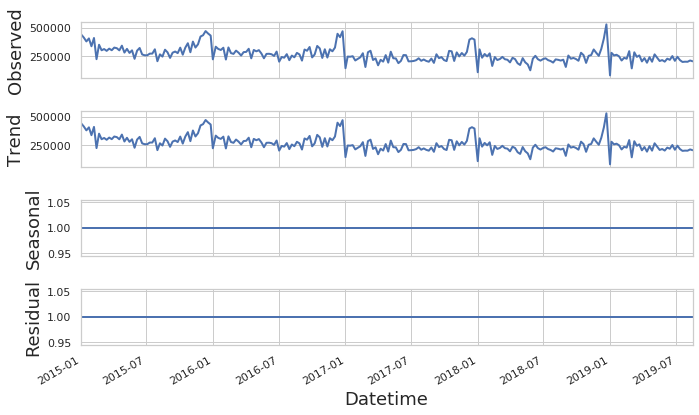

In [0]:
setup_graphics()
from random import randrange
from pandas import Series
from matplotlib import pyplot
from statsmodels.tsa.seasonal import seasonal_decompose
series = df#[df.index > "2016-01-01"]   #[i+randrange(10) for i in range(1,100)]
series = series['ROUTE']
result = seasonal_decompose(series, model='multiplicative', freq=1)
result.plot()
pyplot.show()

In [0]:
series.index

DatetimeIndex(['2016-01-09', '2016-01-16', '2016-01-23', '2016-01-30',
               '2016-02-06', '2016-02-13', '2016-02-20', '2016-02-27',
               '2016-03-05', '2016-03-12',
               ...
               '2019-06-15', '2019-06-22', '2019-06-29', '2019-07-06',
               '2019-07-13', '2019-07-20', '2019-07-27', '2019-08-03',
               '2019-08-10', '2019-08-17'],
              dtype='datetime64[ns]', name='Datetime', length=189, freq=None)

In [0]:
type(series)

pandas.core.series.Series

# Guideline

Previo:
1. Rever oq já esta feito (+encaixar testes estacionariedade)
2. montar scprts pre proc (quais colunas manter)
3. ver como importar .py (ok)
4. montar arquitetura (classes, especialmente pre proc e baseline)
5. funcao pra difference e inverse_difference

Testes previos de estacionariedade (+ decompose):
1. fazer um lineplot dos canais(y), no tempo (x), e quebra por ano (onde tem esse plot? tem no 16 e champagne), 
2. checando estacionariedade: histograma do target (+density plot), med e std anual, boxplots e Ad fuller
3. Decomposicao [y(t) = Level + Trend + Seasonality + Noise], no livro tem um test harness completo disso (verificar quais q tem? ou fz o teste)
4. tirar sazonalidade polyfit() para tirar ambas, ordem 4 ou 5 ou fourier transform
5. Power trans agora?
6. Decidir quais colunas ficam (add no script)

Links:

https://machinelearningmastery.com/decompose-time-series-data-trend-seasonality/ (decomposicao graficos)

https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/?# (decompose)

https://machinelearningmastery.com/time-series-seasonality-with-python/ (polyfit)

https://machinelearningmastery.com/time-series-data-stationary-python/ (estacionariedade e AD fuller)

https://machinelearningmastery.com/time-series-forecast-study-python-monthly-sales-french-champagne/ (case champagne)



---



---



Baseline

1. criar base de teste de modelos (MLM)
2. Tamanho do histórico (sliding window) (ver se tem no harness do livro) 
3. test strategy (champa)
4. univ e multiv // multistep 10 semanas (MAPE e RMSLE) (recursivo, direto?)
5. 5 passos

Links: https://machinelearningmastery.com/simple-time-series-forecasting-models/ (ex test suite nao integrado)

https://machinelearningmastery.com/persistence-time-series-forecasting-with-python/(5 passos)

https://machinelearningmastery.com/multi-step-time-series-forecasting/ (tipos de multi-step, recursivo, direto)

Engenharia de features (testando sobre o baseline):
1. variaveis temporais Sem_Ano
2. diff(t1), MM(t4), diff_lag(1,2), sazonais, #(tirar sazonalidade polyfit() para tirar ambas, ordem 4 ou 5) ou fourier transform
3. testar os t, iterativamente Recursive Feature Selection (RFE). (diz quais os melhores lags)
4. _dpreco p/ outras series c/ pivot (melt desfaz)
5. Expanding Window Statistics (entra no harness?)
6. power transform do target, box-cox transform (log1p) (MLM TS)
7. feature selection
8. teste wilcox

Links:

https://machinelearningmastery.com/power-transform-time-series-forecast-data-python/ (box-cox)

https://machinelearningmastery.com/feature-selection-time-series-forecasting-python/ (RFE e random forest)

https://machinelearningmastery.com/basic-feature-engineering-time-series-data-python/ (expanding window)

 https://machinelearningmastery.com/time-series-forecast-study-python-monthly-sales-french-champagne/ (champa, passa todos e salva)





---



---



Modelos TS/ML:
1. Seguir o guia das familias de modelos
2. Montar o Pipeline ML #MinMaxScaler or StandardScaler (scikit)
3. Montar o test harness dessa etapa (backtest)
4. RF (config mario), LGBM (+NN), XGB(shap) [fig(20,7)], 
5. rmsle, med por canal
6. Ver gráficos de avaliacao + scatter do erro (Vid5)
7. ver se erro residual é gaussiano
8. Salvar e recuperar modelos para teste final
 

 Links:

 https://machinelearningmastery.com/normalize-standardize-time-series-data-python/ (normalize)

 https://machinelearningmastery.com/make-predictions-time-series-forecasting-python/ (finalizar e salvar)

 https://machinelearningmastery.com/time-series-forecast-study-python-monthly-sales-french-champagne/ (champa, passa todos e salva)

https://machinelearningmastery.com/how-to-develop-a-skilful-time-series-forecasting-model/ (familia de modelos)

DL e afins

In [0]:
!pip install ipython-autotime
%load_ext autotime



---



---



# Rascunho series temporais

In [1]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

NameError: ignored

In [0]:
# Set start and end dates
start = '2016-1-1'
end = '2016-2-29'

# Create monthly_dates here
monthly_dates = pd.date_range(start=start, end=end, freq='M')

# Create monthly here
monthly = pd.Series(data=[1,2], index=monthly_dates)
print(monthly)

# Create weekly_dates here
weekly_dates = pd.date_range(start=start, end=end, freq='W')

# Print monthly, reindexed using weekly_dates
print(monthly.reindex(weekly_dates))
print(monthly.reindex(weekly_dates, method='bfill'))
print(monthly.reindex(weekly_dates, method='ffill'))

In [0]:
# Import data here
data = pd.read_csv('unemployment.csv', parse_dates=['date'], index_col='date')

# Show first five rows of weekly series
print(data.asfreq('W').head())

# Show first five rows of weekly series with bfill option
print(data.asfreq('W', method='bfill').head())

# Create weekly series with ffill option and show first five rows
weekly_ffill = data.asfreq('W', method='ffill')
print(weekly_ffill.head())

# Plot weekly_fill starting 2015 here 
weekly_ffill.loc['2015':].plot()
plt.show()

In [0]:
macro_monthly = pd.date_range(start='2015-01-01',end ='2019-11-01', freq='MS')
macro_monthly_ts_pd = pd.Series(index=macro_monthly)

In [0]:
macro_monthly_ts_pd.asfreq('W-SAT')

In [0]:
macro_weekly = macro_monthly_ts_pd.asfreq('W-SAT').to_frame()
#macro_weekly = macro_weekly.to_frame()
macro_weekly



---



---



In [1]:
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [2]:
import tensorflow
print(tensorflow.__version__)

2.1.0


In [0]:
# univariate lstm example
from numpy import array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense

# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

# define input sequence
raw_seq = [10, 20, 30, 40, 50, 60, 70, 80, 90]
# choose a number of time steps
n_steps = 3
# split into samples
X, y = split_sequence(raw_seq, n_steps)


# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))

In [0]:
# define model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [10]:
# fit model
model.fit(X, y, epochs=200, verbose=0)

time: 681 ms


In [11]:
# demonstrate prediction
x_input = array([70, 80, 90])
x_input = x_input.reshape((1, n_steps, n_features))
yhat = model.predict(x_input, verbose=0)
print(yhat)

[[100.671715]]
time: 41.3 ms
